# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [53]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

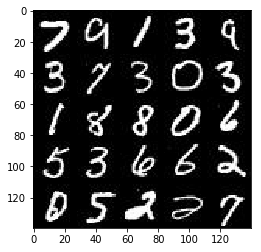

In [54]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

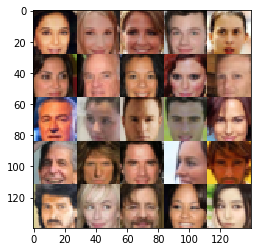

In [55]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [56]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [57]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

### Helper Function for implementing Leaky ReLu

In [58]:
#--->Question: can we use tf.nn.relu6 and/or tf.nn.relu

#not using this helper
# def lrelu(x, leak=0.2, name="lrelu"):
#         with tf.variable_scope(name, reuse=False):
#             f1 = 0.5 * (1 + leak)
#             f2 = 0.5 * (1 - leak)
#             return f1 * x + f2 * abs(x)
    
# #The below functions are taken from carpdem20's implementation https://github.com/carpedm20/DCGAN-tensorflow
# #They allow for saving sample images from the generator to follow progress
# def save_images(images, size, image_path):
#     return imsave(inverse_transform(images), size, image_path)

# def imsave(images, size, path):
#     return scipy.misc.imsave(path, merge(images, size))

# def inverse_transform(images):
#     return (images+1.)/2.

# def merge(images, size):
#     h, w = images.shape[1], images.shape[2]
#     img = np.zeros((h * size[0], w * size[1]))

#     for idx, image in enumerate(images):
#         i = idx % size[1]
#         j = idx // size[1]
#         img[j*h:j*h+h, i*w:i*w+w] = image

#     return img

In [59]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2 #leak param for leaky Relu
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        #print(relu1)
        # 16x16x128
        
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * x2, x2)
        # 8x8x256
        
        x3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * x3, x3)
        # 4x4x512

        # Flatten it
        #flat = tf.reshape(relu3, (-1, 4*4*512))
        flat = tf.contrib.layers.flatten(relu3)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits
    
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [60]:
def generator(z, out_channel_dim, in_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.1 #leaky ReLu
    reuse = not in_train
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=in_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=in_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=in_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [61]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [62]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    # Using TF to update the population statistics while training
    # without this the image quality was very poor, this improves the overall quality
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt




"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [63]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [64]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    steps = 0
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height,image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z,image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    is_train = tf.placeholder(tf.bool)
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                 # Run optimizers
                 # without this the image quality was very poor, this improves the overall quality
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
               
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate,is_train:True})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate,is_train:False})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    #Print the current image
                    show_generator_output(sess, 50, input_z, image_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.3906... Generator Loss: 4.1406
Epoch 1/2... Discriminator Loss: 3.6903... Generator Loss: 21.2566
Epoch 1/2... Discriminator Loss: 2.3315... Generator Loss: 1.7064
Epoch 1/2... Discriminator Loss: 0.6256... Generator Loss: 2.7399
Epoch 1/2... Discriminator Loss: 1.3666... Generator Loss: 0.7290
Epoch 1/2... Discriminator Loss: 1.8578... Generator Loss: 0.4308
Epoch 1/2... Discriminator Loss: 1.5427... Generator Loss: 0.8510
Epoch 1/2... Discriminator Loss: 1.9878... Generator Loss: 1.2282
Epoch 1/2... Discriminator Loss: 1.7992... Generator Loss: 1.0893
Epoch 1/2... Discriminator Loss: 2.1411... Generator Loss: 0.2494


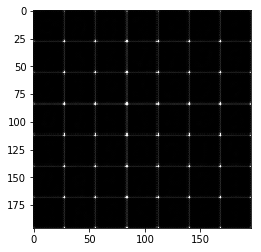

Epoch 1/2... Discriminator Loss: 1.8172... Generator Loss: 0.4993
Epoch 1/2... Discriminator Loss: 1.9023... Generator Loss: 0.3309
Epoch 1/2... Discriminator Loss: 1.5957... Generator Loss: 0.4655
Epoch 1/2... Discriminator Loss: 1.7395... Generator Loss: 1.4335
Epoch 1/2... Discriminator Loss: 1.5780... Generator Loss: 0.4507
Epoch 1/2... Discriminator Loss: 1.4419... Generator Loss: 0.8285
Epoch 1/2... Discriminator Loss: 1.4862... Generator Loss: 0.4979
Epoch 1/2... Discriminator Loss: 1.5149... Generator Loss: 0.4632
Epoch 1/2... Discriminator Loss: 1.5101... Generator Loss: 1.0258
Epoch 1/2... Discriminator Loss: 1.5638... Generator Loss: 0.4867


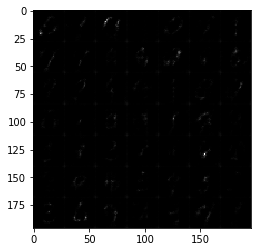

Epoch 1/2... Discriminator Loss: 1.3650... Generator Loss: 0.7571
Epoch 1/2... Discriminator Loss: 1.4306... Generator Loss: 0.7731
Epoch 1/2... Discriminator Loss: 1.9425... Generator Loss: 0.2802
Epoch 1/2... Discriminator Loss: 1.4482... Generator Loss: 0.7659
Epoch 1/2... Discriminator Loss: 1.7021... Generator Loss: 0.3914
Epoch 1/2... Discriminator Loss: 1.5693... Generator Loss: 0.9237
Epoch 1/2... Discriminator Loss: 1.4073... Generator Loss: 0.7941
Epoch 1/2... Discriminator Loss: 1.7782... Generator Loss: 0.3090
Epoch 1/2... Discriminator Loss: 1.5246... Generator Loss: 0.5123
Epoch 1/2... Discriminator Loss: 1.6566... Generator Loss: 0.3810


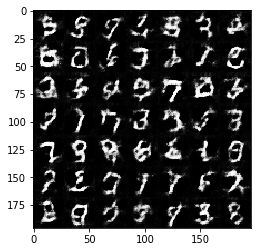

Epoch 1/2... Discriminator Loss: 1.5191... Generator Loss: 0.6859
Epoch 1/2... Discriminator Loss: 1.6222... Generator Loss: 0.4159
Epoch 1/2... Discriminator Loss: 1.5471... Generator Loss: 0.4671
Epoch 1/2... Discriminator Loss: 1.5576... Generator Loss: 0.5144
Epoch 1/2... Discriminator Loss: 1.6023... Generator Loss: 0.4278
Epoch 1/2... Discriminator Loss: 1.4911... Generator Loss: 1.3689
Epoch 1/2... Discriminator Loss: 1.5526... Generator Loss: 0.4562
Epoch 1/2... Discriminator Loss: 1.5022... Generator Loss: 0.5137
Epoch 1/2... Discriminator Loss: 1.6825... Generator Loss: 0.3790
Epoch 1/2... Discriminator Loss: 1.5108... Generator Loss: 0.6411


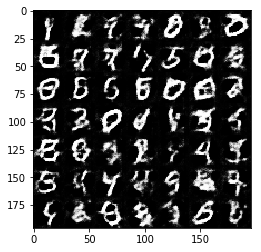

Epoch 1/2... Discriminator Loss: 1.4234... Generator Loss: 0.5252
Epoch 1/2... Discriminator Loss: 1.4284... Generator Loss: 0.6305
Epoch 1/2... Discriminator Loss: 1.5107... Generator Loss: 1.1781
Epoch 1/2... Discriminator Loss: 1.4123... Generator Loss: 0.7321
Epoch 1/2... Discriminator Loss: 1.8632... Generator Loss: 0.2728
Epoch 1/2... Discriminator Loss: 1.5820... Generator Loss: 0.4778
Epoch 1/2... Discriminator Loss: 1.4264... Generator Loss: 0.9242
Epoch 1/2... Discriminator Loss: 1.7022... Generator Loss: 0.3798
Epoch 1/2... Discriminator Loss: 1.4553... Generator Loss: 0.5392
Epoch 1/2... Discriminator Loss: 1.3882... Generator Loss: 0.9081


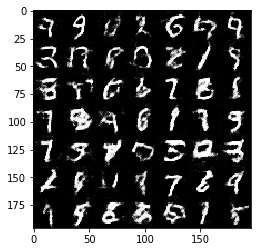

Epoch 1/2... Discriminator Loss: 1.5190... Generator Loss: 0.5368
Epoch 1/2... Discriminator Loss: 1.4740... Generator Loss: 1.1099
Epoch 1/2... Discriminator Loss: 1.7213... Generator Loss: 0.3477
Epoch 1/2... Discriminator Loss: 1.7875... Generator Loss: 0.3086
Epoch 1/2... Discriminator Loss: 1.7413... Generator Loss: 0.3643
Epoch 1/2... Discriminator Loss: 1.4967... Generator Loss: 0.5359
Epoch 1/2... Discriminator Loss: 1.5472... Generator Loss: 1.1401
Epoch 1/2... Discriminator Loss: 1.4069... Generator Loss: 0.6581
Epoch 1/2... Discriminator Loss: 1.6883... Generator Loss: 0.3743
Epoch 1/2... Discriminator Loss: 1.4113... Generator Loss: 0.6687


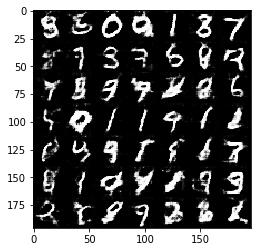

Epoch 1/2... Discriminator Loss: 1.7377... Generator Loss: 0.3497
Epoch 1/2... Discriminator Loss: 1.4499... Generator Loss: 1.3609
Epoch 1/2... Discriminator Loss: 1.3959... Generator Loss: 0.8659
Epoch 1/2... Discriminator Loss: 1.4548... Generator Loss: 0.5852
Epoch 1/2... Discriminator Loss: 1.3788... Generator Loss: 0.7911
Epoch 1/2... Discriminator Loss: 1.4350... Generator Loss: 0.9914
Epoch 1/2... Discriminator Loss: 1.4846... Generator Loss: 0.5153
Epoch 1/2... Discriminator Loss: 1.4943... Generator Loss: 0.5736
Epoch 1/2... Discriminator Loss: 1.3325... Generator Loss: 0.7676
Epoch 1/2... Discriminator Loss: 1.5517... Generator Loss: 0.8412


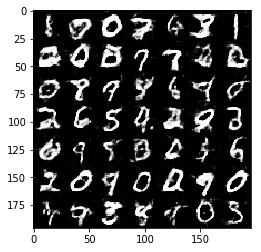

Epoch 1/2... Discriminator Loss: 1.3481... Generator Loss: 0.8475
Epoch 1/2... Discriminator Loss: 1.5709... Generator Loss: 1.0680
Epoch 1/2... Discriminator Loss: 1.5293... Generator Loss: 0.4872
Epoch 1/2... Discriminator Loss: 1.5020... Generator Loss: 0.4832
Epoch 1/2... Discriminator Loss: 1.2904... Generator Loss: 1.0020
Epoch 1/2... Discriminator Loss: 1.3545... Generator Loss: 0.9313
Epoch 1/2... Discriminator Loss: 1.4358... Generator Loss: 0.7771
Epoch 1/2... Discriminator Loss: 1.3831... Generator Loss: 0.5526
Epoch 1/2... Discriminator Loss: 1.5489... Generator Loss: 0.4471
Epoch 1/2... Discriminator Loss: 1.4596... Generator Loss: 0.6217


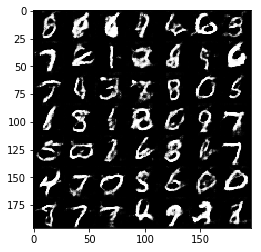

Epoch 1/2... Discriminator Loss: 1.8179... Generator Loss: 0.2847
Epoch 1/2... Discriminator Loss: 1.3117... Generator Loss: 0.7601
Epoch 1/2... Discriminator Loss: 1.4924... Generator Loss: 0.5931
Epoch 1/2... Discriminator Loss: 1.4512... Generator Loss: 0.8136
Epoch 1/2... Discriminator Loss: 1.6928... Generator Loss: 0.3311
Epoch 1/2... Discriminator Loss: 1.2655... Generator Loss: 0.7731
Epoch 1/2... Discriminator Loss: 1.5480... Generator Loss: 0.4303
Epoch 1/2... Discriminator Loss: 1.4692... Generator Loss: 0.7347
Epoch 1/2... Discriminator Loss: 1.4445... Generator Loss: 0.6491
Epoch 1/2... Discriminator Loss: 1.5602... Generator Loss: 0.4018


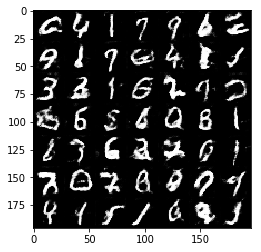

Epoch 1/2... Discriminator Loss: 1.3350... Generator Loss: 1.0390
Epoch 1/2... Discriminator Loss: 2.5273... Generator Loss: 0.1469
Epoch 1/2... Discriminator Loss: 1.3565... Generator Loss: 0.6329
Epoch 2/2... Discriminator Loss: 1.3393... Generator Loss: 1.0692
Epoch 2/2... Discriminator Loss: 1.5090... Generator Loss: 0.4918
Epoch 2/2... Discriminator Loss: 1.3688... Generator Loss: 0.6394
Epoch 2/2... Discriminator Loss: 1.3686... Generator Loss: 0.5716
Epoch 2/2... Discriminator Loss: 1.4718... Generator Loss: 1.3603
Epoch 2/2... Discriminator Loss: 1.5032... Generator Loss: 0.4844
Epoch 2/2... Discriminator Loss: 1.8072... Generator Loss: 0.3270


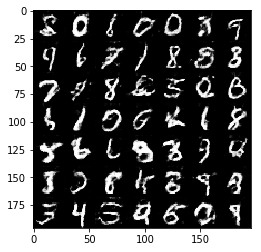

Epoch 2/2... Discriminator Loss: 1.3971... Generator Loss: 0.6017
Epoch 2/2... Discriminator Loss: 1.5907... Generator Loss: 0.6078
Epoch 2/2... Discriminator Loss: 1.5991... Generator Loss: 0.3839
Epoch 2/2... Discriminator Loss: 1.3545... Generator Loss: 0.6369
Epoch 2/2... Discriminator Loss: 1.6795... Generator Loss: 0.3759
Epoch 2/2... Discriminator Loss: 1.5764... Generator Loss: 0.4114
Epoch 2/2... Discriminator Loss: 1.4717... Generator Loss: 0.5183
Epoch 2/2... Discriminator Loss: 1.4137... Generator Loss: 0.5915
Epoch 2/2... Discriminator Loss: 1.7622... Generator Loss: 0.3169
Epoch 2/2... Discriminator Loss: 1.5936... Generator Loss: 0.3988


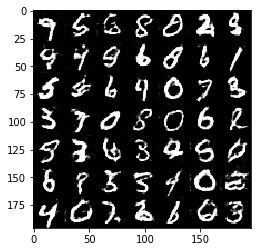

Epoch 2/2... Discriminator Loss: 1.3783... Generator Loss: 0.6689
Epoch 2/2... Discriminator Loss: 1.4267... Generator Loss: 0.6238
Epoch 2/2... Discriminator Loss: 2.7287... Generator Loss: 1.5022
Epoch 2/2... Discriminator Loss: 1.4372... Generator Loss: 0.7085
Epoch 2/2... Discriminator Loss: 1.4632... Generator Loss: 0.5833
Epoch 2/2... Discriminator Loss: 1.3837... Generator Loss: 0.9530
Epoch 2/2... Discriminator Loss: 1.3142... Generator Loss: 0.6950
Epoch 2/2... Discriminator Loss: 1.6066... Generator Loss: 1.4341
Epoch 2/2... Discriminator Loss: 1.3712... Generator Loss: 0.5842
Epoch 2/2... Discriminator Loss: 1.9906... Generator Loss: 0.2683


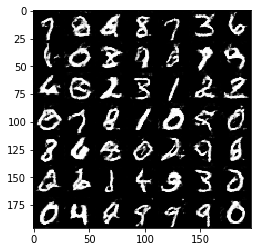

Epoch 2/2... Discriminator Loss: 1.4588... Generator Loss: 0.4973
Epoch 2/2... Discriminator Loss: 1.5774... Generator Loss: 0.7735
Epoch 2/2... Discriminator Loss: 1.5864... Generator Loss: 0.4801
Epoch 2/2... Discriminator Loss: 1.4358... Generator Loss: 0.6111
Epoch 2/2... Discriminator Loss: 1.4836... Generator Loss: 1.1314
Epoch 2/2... Discriminator Loss: 1.3004... Generator Loss: 0.8971
Epoch 2/2... Discriminator Loss: 1.3502... Generator Loss: 0.6871
Epoch 2/2... Discriminator Loss: 1.4641... Generator Loss: 0.5389
Epoch 2/2... Discriminator Loss: 1.7280... Generator Loss: 0.3275
Epoch 2/2... Discriminator Loss: 1.4458... Generator Loss: 0.5584


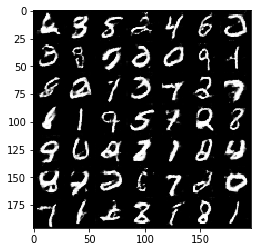

Epoch 2/2... Discriminator Loss: 1.3675... Generator Loss: 1.0410
Epoch 2/2... Discriminator Loss: 1.3734... Generator Loss: 0.5478
Epoch 2/2... Discriminator Loss: 1.4874... Generator Loss: 0.4356
Epoch 2/2... Discriminator Loss: 1.5666... Generator Loss: 0.4130
Epoch 2/2... Discriminator Loss: 1.6910... Generator Loss: 0.3388
Epoch 2/2... Discriminator Loss: 1.8680... Generator Loss: 0.2802
Epoch 2/2... Discriminator Loss: 1.4326... Generator Loss: 0.5523
Epoch 2/2... Discriminator Loss: 1.6265... Generator Loss: 0.4202
Epoch 2/2... Discriminator Loss: 1.4989... Generator Loss: 0.5976
Epoch 2/2... Discriminator Loss: 1.7988... Generator Loss: 0.3023


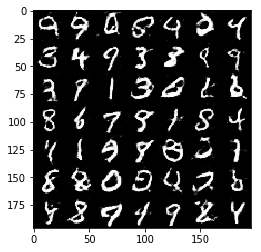

Epoch 2/2... Discriminator Loss: 1.6770... Generator Loss: 0.3515
Epoch 2/2... Discriminator Loss: 1.4751... Generator Loss: 0.6750
Epoch 2/2... Discriminator Loss: 1.6028... Generator Loss: 0.4234
Epoch 2/2... Discriminator Loss: 1.3404... Generator Loss: 0.7992
Epoch 2/2... Discriminator Loss: 1.6526... Generator Loss: 0.3542
Epoch 2/2... Discriminator Loss: 1.2870... Generator Loss: 0.7527
Epoch 2/2... Discriminator Loss: 1.4534... Generator Loss: 0.6853
Epoch 2/2... Discriminator Loss: 1.3372... Generator Loss: 0.8406
Epoch 2/2... Discriminator Loss: 1.5299... Generator Loss: 0.4846
Epoch 2/2... Discriminator Loss: 1.4009... Generator Loss: 1.0355


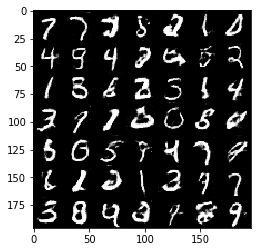

Epoch 2/2... Discriminator Loss: 1.7376... Generator Loss: 0.3380
Epoch 2/2... Discriminator Loss: 2.0118... Generator Loss: 1.0122
Epoch 2/2... Discriminator Loss: 1.3358... Generator Loss: 0.9308
Epoch 2/2... Discriminator Loss: 1.3360... Generator Loss: 0.7964
Epoch 2/2... Discriminator Loss: 1.3090... Generator Loss: 0.8394
Epoch 2/2... Discriminator Loss: 1.4507... Generator Loss: 0.6460
Epoch 2/2... Discriminator Loss: 1.7389... Generator Loss: 0.3375
Epoch 2/2... Discriminator Loss: 1.2525... Generator Loss: 1.5424
Epoch 2/2... Discriminator Loss: 1.3504... Generator Loss: 0.7536
Epoch 2/2... Discriminator Loss: 1.3631... Generator Loss: 0.8067


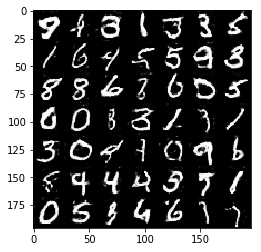

Epoch 2/2... Discriminator Loss: 1.7602... Generator Loss: 0.3604
Epoch 2/2... Discriminator Loss: 1.4744... Generator Loss: 0.4699
Epoch 2/2... Discriminator Loss: 1.1302... Generator Loss: 1.1404
Epoch 2/2... Discriminator Loss: 1.2409... Generator Loss: 0.8242
Epoch 2/2... Discriminator Loss: 1.3276... Generator Loss: 0.7299
Epoch 2/2... Discriminator Loss: 1.4197... Generator Loss: 1.6786
Epoch 2/2... Discriminator Loss: 1.3722... Generator Loss: 0.5598
Epoch 2/2... Discriminator Loss: 1.4563... Generator Loss: 0.8944
Epoch 2/2... Discriminator Loss: 1.2875... Generator Loss: 0.6183
Epoch 2/2... Discriminator Loss: 1.3336... Generator Loss: 0.5602


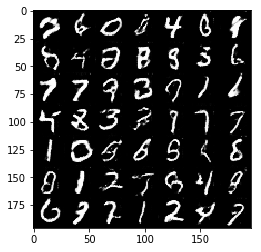

Epoch 2/2... Discriminator Loss: 1.7024... Generator Loss: 0.3522
Epoch 2/2... Discriminator Loss: 1.3921... Generator Loss: 0.7411
Epoch 2/2... Discriminator Loss: 1.4571... Generator Loss: 0.5442
Epoch 2/2... Discriminator Loss: 1.3553... Generator Loss: 0.8719
Epoch 2/2... Discriminator Loss: 1.3942... Generator Loss: 0.6307
Epoch 2/2... Discriminator Loss: 1.7042... Generator Loss: 0.3643
Epoch 2/2... Discriminator Loss: 1.2075... Generator Loss: 0.9923
Epoch 2/2... Discriminator Loss: 1.2912... Generator Loss: 0.6298
Epoch 2/2... Discriminator Loss: 1.5974... Generator Loss: 0.3984
Epoch 2/2... Discriminator Loss: 1.4622... Generator Loss: 0.4629


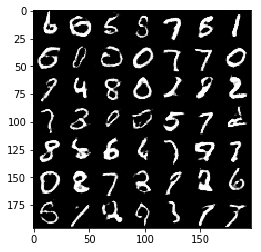

Epoch 2/2... Discriminator Loss: 1.4596... Generator Loss: 0.4693
Epoch 2/2... Discriminator Loss: 1.4360... Generator Loss: 0.5483
Epoch 2/2... Discriminator Loss: 1.4246... Generator Loss: 0.5587
Epoch 2/2... Discriminator Loss: 1.4313... Generator Loss: 0.5193
Epoch 2/2... Discriminator Loss: 1.4701... Generator Loss: 0.6184
Epoch 2/2... Discriminator Loss: 1.4213... Generator Loss: 0.6009
Epoch 2/2... Discriminator Loss: 1.3846... Generator Loss: 0.7296


In [65]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002 #0.0001 is that not effective
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.1563... Generator Loss: 0.1304
Epoch 1/1... Discriminator Loss: 2.9616... Generator Loss: 0.0991
Epoch 1/1... Discriminator Loss: 2.1265... Generator Loss: 0.3347
Epoch 1/1... Discriminator Loss: 1.7086... Generator Loss: 0.9042
Epoch 1/1... Discriminator Loss: 1.6084... Generator Loss: 0.8310
Epoch 1/1... Discriminator Loss: 2.2273... Generator Loss: 0.7224
Epoch 1/1... Discriminator Loss: 1.6968... Generator Loss: 0.6727
Epoch 1/1... Discriminator Loss: 1.8610... Generator Loss: 0.4980
Epoch 1/1... Discriminator Loss: 1.8618... Generator Loss: 0.4788
Epoch 1/1... Discriminator Loss: 1.5224... Generator Loss: 2.0569


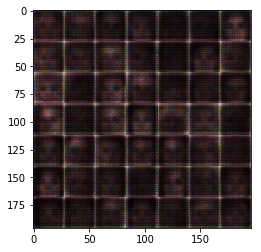

Epoch 1/1... Discriminator Loss: 1.4858... Generator Loss: 0.8614
Epoch 1/1... Discriminator Loss: 1.6511... Generator Loss: 0.7874
Epoch 1/1... Discriminator Loss: 2.2815... Generator Loss: 0.2908
Epoch 1/1... Discriminator Loss: 1.7156... Generator Loss: 0.6766
Epoch 1/1... Discriminator Loss: 1.6339... Generator Loss: 0.6344
Epoch 1/1... Discriminator Loss: 1.4596... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 1.7028... Generator Loss: 0.4423
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.7506
Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.5105
Epoch 1/1... Discriminator Loss: 1.7265... Generator Loss: 0.3844


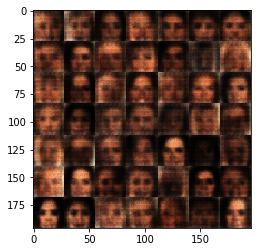

Epoch 1/1... Discriminator Loss: 0.8486... Generator Loss: 2.0611
Epoch 1/1... Discriminator Loss: 1.8448... Generator Loss: 2.2974
Epoch 1/1... Discriminator Loss: 1.6859... Generator Loss: 0.4675
Epoch 1/1... Discriminator Loss: 1.6773... Generator Loss: 1.3752
Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 0.8579
Epoch 1/1... Discriminator Loss: 1.7312... Generator Loss: 0.3830
Epoch 1/1... Discriminator Loss: 1.6323... Generator Loss: 0.4336
Epoch 1/1... Discriminator Loss: 1.6403... Generator Loss: 0.4425
Epoch 1/1... Discriminator Loss: 1.6450... Generator Loss: 0.9909
Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.7217


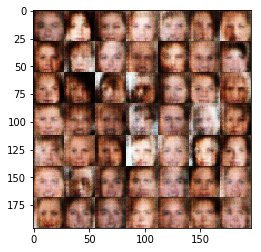

Epoch 1/1... Discriminator Loss: 1.5521... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 1.5168... Generator Loss: 0.6593
Epoch 1/1... Discriminator Loss: 1.5193... Generator Loss: 0.7916
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.7886
Epoch 1/1... Discriminator Loss: 1.6406... Generator Loss: 0.7087
Epoch 1/1... Discriminator Loss: 1.6978... Generator Loss: 0.5971
Epoch 1/1... Discriminator Loss: 1.4506... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 1.4635... Generator Loss: 0.8550
Epoch 1/1... Discriminator Loss: 1.5114... Generator Loss: 0.8062
Epoch 1/1... Discriminator Loss: 1.5864... Generator Loss: 0.6155


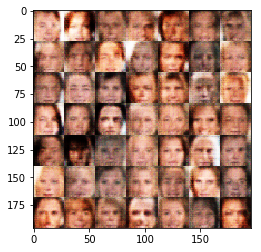

Epoch 1/1... Discriminator Loss: 1.4981... Generator Loss: 0.6565
Epoch 1/1... Discriminator Loss: 1.5463... Generator Loss: 0.6051
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.6851
Epoch 1/1... Discriminator Loss: 1.6003... Generator Loss: 0.6277
Epoch 1/1... Discriminator Loss: 1.5548... Generator Loss: 0.6212
Epoch 1/1... Discriminator Loss: 1.5155... Generator Loss: 0.6868
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.7156
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.8213
Epoch 1/1... Discriminator Loss: 1.5432... Generator Loss: 0.7334
Epoch 1/1... Discriminator Loss: 1.4516... Generator Loss: 0.7874


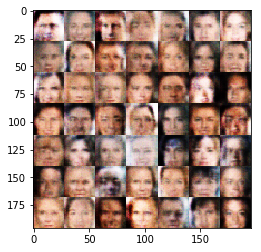

Epoch 1/1... Discriminator Loss: 1.4411... Generator Loss: 0.8277
Epoch 1/1... Discriminator Loss: 1.5856... Generator Loss: 0.5957
Epoch 1/1... Discriminator Loss: 1.5296... Generator Loss: 0.7394
Epoch 1/1... Discriminator Loss: 1.5569... Generator Loss: 0.6312
Epoch 1/1... Discriminator Loss: 1.5149... Generator Loss: 0.6617
Epoch 1/1... Discriminator Loss: 1.4810... Generator Loss: 0.7211
Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.8971
Epoch 1/1... Discriminator Loss: 1.4993... Generator Loss: 0.8044
Epoch 1/1... Discriminator Loss: 1.4690... Generator Loss: 0.7420
Epoch 1/1... Discriminator Loss: 1.3452... Generator Loss: 0.8391


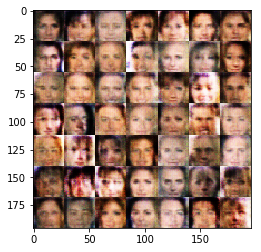

Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 0.8667
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.8483
Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 1.5743... Generator Loss: 0.5849
Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.7386
Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 0.8587
Epoch 1/1... Discriminator Loss: 1.5325... Generator Loss: 0.5919
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.7895
Epoch 1/1... Discriminator Loss: 1.5237... Generator Loss: 0.6127
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.7800


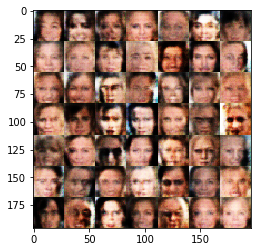

Epoch 1/1... Discriminator Loss: 1.4940... Generator Loss: 0.9479
Epoch 1/1... Discriminator Loss: 1.2672... Generator Loss: 1.0635
Epoch 1/1... Discriminator Loss: 1.3065... Generator Loss: 0.7618
Epoch 1/1... Discriminator Loss: 1.2494... Generator Loss: 1.3029
Epoch 1/1... Discriminator Loss: 1.2401... Generator Loss: 0.6874
Epoch 1/1... Discriminator Loss: 1.2066... Generator Loss: 0.6917
Epoch 1/1... Discriminator Loss: 1.4809... Generator Loss: 0.4698
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 1.6775
Epoch 1/1... Discriminator Loss: 1.7955... Generator Loss: 0.3407
Epoch 1/1... Discriminator Loss: 1.0419... Generator Loss: 1.5412


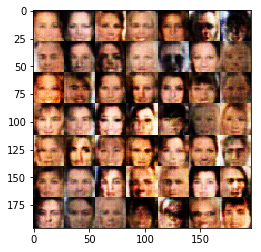

Epoch 1/1... Discriminator Loss: 1.2668... Generator Loss: 0.9684
Epoch 1/1... Discriminator Loss: 1.3327... Generator Loss: 2.8723
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.5656
Epoch 1/1... Discriminator Loss: 1.2696... Generator Loss: 0.6313
Epoch 1/1... Discriminator Loss: 1.6278... Generator Loss: 0.4220
Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.7938
Epoch 1/1... Discriminator Loss: 1.2079... Generator Loss: 1.0547
Epoch 1/1... Discriminator Loss: 1.0168... Generator Loss: 2.1756
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.7267
Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 0.9365


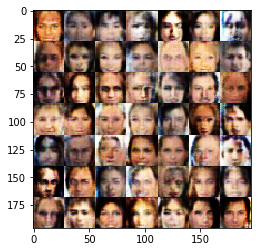

Epoch 1/1... Discriminator Loss: 1.5536... Generator Loss: 0.5260
Epoch 1/1... Discriminator Loss: 1.5230... Generator Loss: 0.4521
Epoch 1/1... Discriminator Loss: 1.5173... Generator Loss: 1.1227
Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 0.7431
Epoch 1/1... Discriminator Loss: 1.7300... Generator Loss: 0.3967
Epoch 1/1... Discriminator Loss: 1.5552... Generator Loss: 0.5655
Epoch 1/1... Discriminator Loss: 1.3014... Generator Loss: 0.9942
Epoch 1/1... Discriminator Loss: 1.2633... Generator Loss: 1.0069
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.7613
Epoch 1/1... Discriminator Loss: 1.6949... Generator Loss: 0.3790


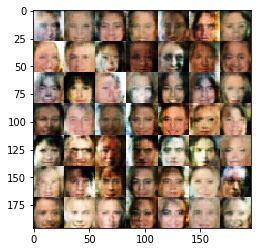

Epoch 1/1... Discriminator Loss: 1.7124... Generator Loss: 0.4195
Epoch 1/1... Discriminator Loss: 1.6399... Generator Loss: 0.4462
Epoch 1/1... Discriminator Loss: 1.5721... Generator Loss: 0.7125
Epoch 1/1... Discriminator Loss: 1.3578... Generator Loss: 0.8985
Epoch 1/1... Discriminator Loss: 1.5535... Generator Loss: 0.6234
Epoch 1/1... Discriminator Loss: 1.6145... Generator Loss: 0.6327
Epoch 1/1... Discriminator Loss: 1.5281... Generator Loss: 0.6949
Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 0.7210
Epoch 1/1... Discriminator Loss: 1.3330... Generator Loss: 0.7400
Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.7492


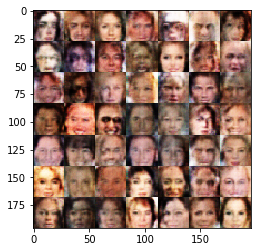

Epoch 1/1... Discriminator Loss: 1.4467... Generator Loss: 0.6690
Epoch 1/1... Discriminator Loss: 1.4841... Generator Loss: 0.6225
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.8062
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.8070
Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 0.7929
Epoch 1/1... Discriminator Loss: 1.5800... Generator Loss: 0.6771
Epoch 1/1... Discriminator Loss: 1.4776... Generator Loss: 0.6192
Epoch 1/1... Discriminator Loss: 1.4609... Generator Loss: 0.8117
Epoch 1/1... Discriminator Loss: 1.5540... Generator Loss: 0.7319


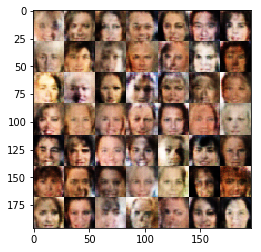

Epoch 1/1... Discriminator Loss: 1.4772... Generator Loss: 0.7084
Epoch 1/1... Discriminator Loss: 1.4605... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 1.4288... Generator Loss: 0.7931
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.6804
Epoch 1/1... Discriminator Loss: 1.4844... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 1.4779... Generator Loss: 0.6233
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.6965
Epoch 1/1... Discriminator Loss: 1.4841... Generator Loss: 0.7070
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.6934
Epoch 1/1... Discriminator Loss: 1.4485... Generator Loss: 0.6917


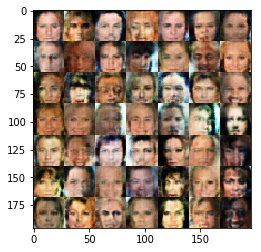

Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.7728
Epoch 1/1... Discriminator Loss: 1.4720... Generator Loss: 0.7083
Epoch 1/1... Discriminator Loss: 1.4500... Generator Loss: 0.7112
Epoch 1/1... Discriminator Loss: 1.4451... Generator Loss: 0.7519
Epoch 1/1... Discriminator Loss: 1.4517... Generator Loss: 0.7302
Epoch 1/1... Discriminator Loss: 1.4551... Generator Loss: 0.7647
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.7437
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.7889
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.7331
Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 0.7577


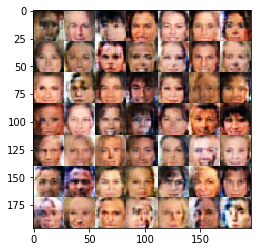

Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.7592
Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 0.8489
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.8083
Epoch 1/1... Discriminator Loss: 1.4887... Generator Loss: 0.6608
Epoch 1/1... Discriminator Loss: 1.4712... Generator Loss: 0.6972
Epoch 1/1... Discriminator Loss: 1.4719... Generator Loss: 0.7288
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.6673
Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.7873
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.8331
Epoch 1/1... Discriminator Loss: 1.4615... Generator Loss: 0.6550


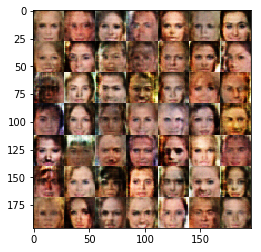

Epoch 1/1... Discriminator Loss: 1.3808... Generator Loss: 0.8208
Epoch 1/1... Discriminator Loss: 1.4614... Generator Loss: 0.6700
Epoch 1/1... Discriminator Loss: 1.5130... Generator Loss: 0.5998
Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 0.7874
Epoch 1/1... Discriminator Loss: 1.5554... Generator Loss: 0.6096
Epoch 1/1... Discriminator Loss: 1.4924... Generator Loss: 0.6863
Epoch 1/1... Discriminator Loss: 1.4854... Generator Loss: 0.6772
Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.7443
Epoch 1/1... Discriminator Loss: 1.4769... Generator Loss: 0.7127


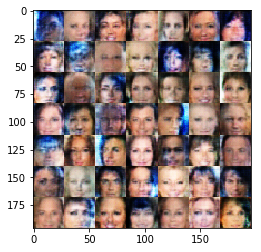

Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.7567
Epoch 1/1... Discriminator Loss: 1.3613... Generator Loss: 0.8862
Epoch 1/1... Discriminator Loss: 1.4562... Generator Loss: 0.7350
Epoch 1/1... Discriminator Loss: 1.4434... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 1.3603... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.5691... Generator Loss: 0.6996
Epoch 1/1... Discriminator Loss: 1.5115... Generator Loss: 0.6774
Epoch 1/1... Discriminator Loss: 1.2818... Generator Loss: 0.8444
Epoch 1/1... Discriminator Loss: 1.4744... Generator Loss: 0.7163
Epoch 1/1... Discriminator Loss: 1.4724... Generator Loss: 0.6190


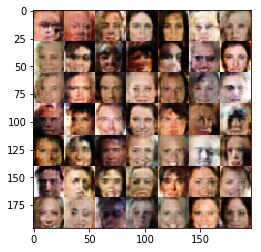

Epoch 1/1... Discriminator Loss: 1.4993... Generator Loss: 0.5926
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.6519
Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 0.7331
Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.9146
Epoch 1/1... Discriminator Loss: 1.2456... Generator Loss: 0.9460
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.7363
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.7600
Epoch 1/1... Discriminator Loss: 1.5813... Generator Loss: 0.5195
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.6382
Epoch 1/1... Discriminator Loss: 1.2448... Generator Loss: 0.8334


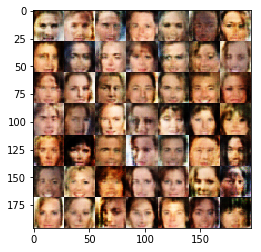

Epoch 1/1... Discriminator Loss: 1.4461... Generator Loss: 0.6260
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.9611
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.7401
Epoch 1/1... Discriminator Loss: 1.4923... Generator Loss: 0.6220
Epoch 1/1... Discriminator Loss: 1.4742... Generator Loss: 0.6091
Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.6939
Epoch 1/1... Discriminator Loss: 1.5647... Generator Loss: 0.6080
Epoch 1/1... Discriminator Loss: 1.5547... Generator Loss: 0.6277
Epoch 1/1... Discriminator Loss: 1.3489... Generator Loss: 0.9654
Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.6513


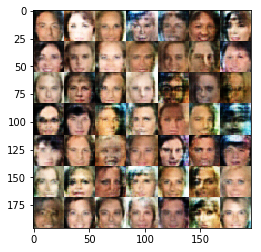

Epoch 1/1... Discriminator Loss: 1.5824... Generator Loss: 0.5614
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.8060
Epoch 1/1... Discriminator Loss: 1.3346... Generator Loss: 0.8946
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.6906
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.7760
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.7172
Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.7153
Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.6429
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.6228
Epoch 1/1... Discriminator Loss: 1.4640... Generator Loss: 0.4710


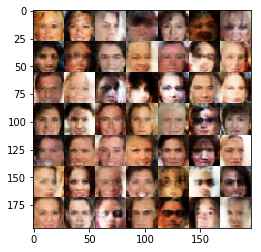

Epoch 1/1... Discriminator Loss: 1.2271... Generator Loss: 1.0205
Epoch 1/1... Discriminator Loss: 1.4856... Generator Loss: 0.5979
Epoch 1/1... Discriminator Loss: 1.3488... Generator Loss: 0.6829
Epoch 1/1... Discriminator Loss: 1.5070... Generator Loss: 0.6517
Epoch 1/1... Discriminator Loss: 1.5815... Generator Loss: 0.5419
Epoch 1/1... Discriminator Loss: 1.2428... Generator Loss: 1.1810
Epoch 1/1... Discriminator Loss: 1.6775... Generator Loss: 0.3959
Epoch 1/1... Discriminator Loss: 1.6715... Generator Loss: 0.3993
Epoch 1/1... Discriminator Loss: 1.6040... Generator Loss: 0.5590
Epoch 1/1... Discriminator Loss: 1.1964... Generator Loss: 1.0813


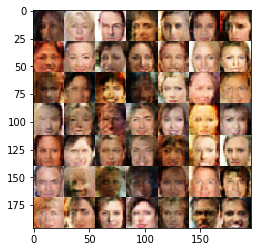

Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.6760
Epoch 1/1... Discriminator Loss: 1.5353... Generator Loss: 0.5525
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.8080
Epoch 1/1... Discriminator Loss: 1.6143... Generator Loss: 0.4529
Epoch 1/1... Discriminator Loss: 1.5626... Generator Loss: 0.5998
Epoch 1/1... Discriminator Loss: 1.5492... Generator Loss: 0.6505
Epoch 1/1... Discriminator Loss: 1.5368... Generator Loss: 0.5954
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.7831
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.6813
Epoch 1/1... Discriminator Loss: 1.5047... Generator Loss: 0.6289


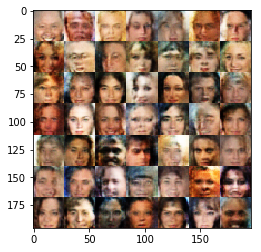

Epoch 1/1... Discriminator Loss: 1.5068... Generator Loss: 0.7275
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.9028
Epoch 1/1... Discriminator Loss: 1.2300... Generator Loss: 1.0821
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.9681
Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.4375... Generator Loss: 0.7180
Epoch 1/1... Discriminator Loss: 1.4514... Generator Loss: 0.6001
Epoch 1/1... Discriminator Loss: 1.5137... Generator Loss: 0.5959
Epoch 1/1... Discriminator Loss: 1.4824... Generator Loss: 0.7940
Epoch 1/1... Discriminator Loss: 1.4397... Generator Loss: 0.5948


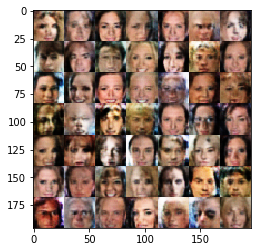

Epoch 1/1... Discriminator Loss: 1.2894... Generator Loss: 0.8746
Epoch 1/1... Discriminator Loss: 1.5750... Generator Loss: 0.5693
Epoch 1/1... Discriminator Loss: 1.6417... Generator Loss: 0.6107
Epoch 1/1... Discriminator Loss: 1.5077... Generator Loss: 0.6380
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.7679
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.6740
Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.6899
Epoch 1/1... Discriminator Loss: 1.3502... Generator Loss: 0.8096
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.6894
Epoch 1/1... Discriminator Loss: 1.4832... Generator Loss: 0.7121


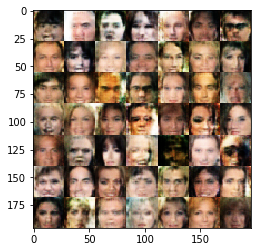

Epoch 1/1... Discriminator Loss: 1.3349... Generator Loss: 1.0173
Epoch 1/1... Discriminator Loss: 1.5364... Generator Loss: 0.5520
Epoch 1/1... Discriminator Loss: 1.3550... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 1.5527... Generator Loss: 0.5568
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.7063
Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 0.6479
Epoch 1/1... Discriminator Loss: 1.6504... Generator Loss: 0.5167
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.7158
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.8710
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.7377


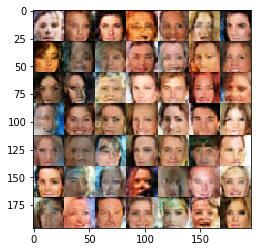

Epoch 1/1... Discriminator Loss: 1.2941... Generator Loss: 1.0034
Epoch 1/1... Discriminator Loss: 1.6343... Generator Loss: 0.5034
Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 0.8179
Epoch 1/1... Discriminator Loss: 1.4823... Generator Loss: 0.6192
Epoch 1/1... Discriminator Loss: 1.5515... Generator Loss: 0.5507
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.7836
Epoch 1/1... Discriminator Loss: 1.6099... Generator Loss: 0.4544
Epoch 1/1... Discriminator Loss: 1.5120... Generator Loss: 0.6323
Epoch 1/1... Discriminator Loss: 1.1930... Generator Loss: 1.1769
Epoch 1/1... Discriminator Loss: 1.2550... Generator Loss: 1.1892


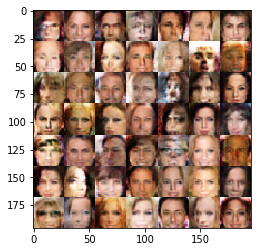

Epoch 1/1... Discriminator Loss: 1.5135... Generator Loss: 0.4847
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.8980
Epoch 1/1... Discriminator Loss: 1.5212... Generator Loss: 0.5787
Epoch 1/1... Discriminator Loss: 1.4384... Generator Loss: 0.6432
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.7245
Epoch 1/1... Discriminator Loss: 1.5693... Generator Loss: 0.4880
Epoch 1/1... Discriminator Loss: 1.2762... Generator Loss: 0.9474
Epoch 1/1... Discriminator Loss: 1.5179... Generator Loss: 0.5475
Epoch 1/1... Discriminator Loss: 1.3574... Generator Loss: 0.7067
Epoch 1/1... Discriminator Loss: 1.5511... Generator Loss: 0.6099


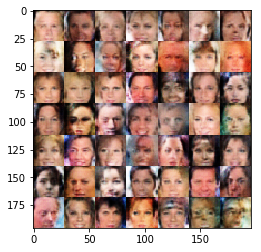

Epoch 1/1... Discriminator Loss: 1.3078... Generator Loss: 0.9882
Epoch 1/1... Discriminator Loss: 1.6684... Generator Loss: 0.5007
Epoch 1/1... Discriminator Loss: 1.3614... Generator Loss: 0.6890
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.6010
Epoch 1/1... Discriminator Loss: 1.2601... Generator Loss: 0.9829
Epoch 1/1... Discriminator Loss: 1.5763... Generator Loss: 0.5363
Epoch 1/1... Discriminator Loss: 1.5361... Generator Loss: 0.4858
Epoch 1/1... Discriminator Loss: 1.6288... Generator Loss: 0.4486
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.8140
Epoch 1/1... Discriminator Loss: 1.2476... Generator Loss: 1.1244


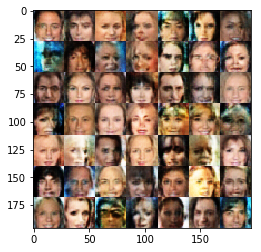

Epoch 1/1... Discriminator Loss: 1.7133... Generator Loss: 0.3688
Epoch 1/1... Discriminator Loss: 1.0599... Generator Loss: 1.1049
Epoch 1/1... Discriminator Loss: 1.4668... Generator Loss: 0.8868
Epoch 1/1... Discriminator Loss: 1.5680... Generator Loss: 0.4924
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.5697
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.6366
Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 0.5683
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 1.2068
Epoch 1/1... Discriminator Loss: 1.2913... Generator Loss: 0.8058
Epoch 1/1... Discriminator Loss: 1.2752... Generator Loss: 1.0883


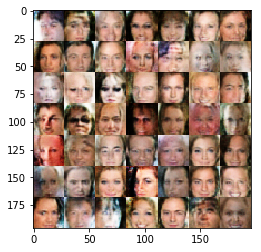

Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.7506
Epoch 1/1... Discriminator Loss: 1.2878... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 0.6949
Epoch 1/1... Discriminator Loss: 1.2676... Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 1.3191... Generator Loss: 0.9057
Epoch 1/1... Discriminator Loss: 1.4395... Generator Loss: 0.5575
Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 0.9989
Epoch 1/1... Discriminator Loss: 1.2789... Generator Loss: 0.8417
Epoch 1/1... Discriminator Loss: 1.2410... Generator Loss: 1.2725
Epoch 1/1... Discriminator Loss: 1.4531... Generator Loss: 0.8791


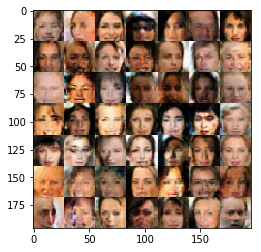

Epoch 1/1... Discriminator Loss: 1.2694... Generator Loss: 0.7993
Epoch 1/1... Discriminator Loss: 1.5594... Generator Loss: 0.5342
Epoch 1/1... Discriminator Loss: 1.2960... Generator Loss: 1.0089
Epoch 1/1... Discriminator Loss: 1.4546... Generator Loss: 0.6276
Epoch 1/1... Discriminator Loss: 1.4546... Generator Loss: 0.7083
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.9257
Epoch 1/1... Discriminator Loss: 1.3535... Generator Loss: 0.8749
Epoch 1/1... Discriminator Loss: 1.2581... Generator Loss: 0.9956
Epoch 1/1... Discriminator Loss: 1.4543... Generator Loss: 0.6258
Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.6761


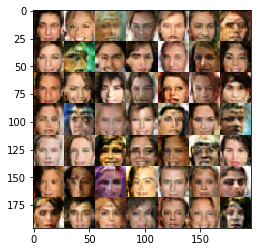

Epoch 1/1... Discriminator Loss: 1.4848... Generator Loss: 0.5048
Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 0.5666
Epoch 1/1... Discriminator Loss: 1.3298... Generator Loss: 0.8203
Epoch 1/1... Discriminator Loss: 1.6059... Generator Loss: 0.4192
Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 0.6894
Epoch 1/1... Discriminator Loss: 1.5270... Generator Loss: 0.4940


In [66]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001 #0.001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.